In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import os
import tflearn
from utils import *
os.environ["CUDA_VISIBLE_DEVICES"]='1'
# mnist_data = input_data.read_data_sets("MNIST_data", one_hot=True)

# Try on the simulated data first

In [2]:
def generate_lin_sep_blobs_3(n_samples, random_state):
# 	samples = make_blobs(n_samples=n_samples, n_features=2,
# 		centers=[(0.2, 0.2), (0.8, 0.8)], cluster_std=0.1,
# 		random_state=random_state)
# 	samples = make_blobs(n_samples=n_samples, n_features=2,
# 		centers=[(-30, -30), (0, 40), (30, -30)], cluster_std=5,
# 		random_state=random_state)
	samples = make_blobs(n_samples=n_samples, n_features=2,
		centers=[(10, 10), (45, 75), (80, 10)], cluster_std=5,
		random_state=random_state)
	return samples[0], samples[1]

In [3]:
def plot_blobs_3(feature, label, name=None):
    pylab.figure()
    red = feature[label == 0]
    blue = feature[label == 1]
    green = feature[label == 2]
    pylab.plot(red[:, 0], red[:, 1], 'g.')
    pylab.plot(blue[:, 0], blue[:, 1], 'k.')
    pylab.plot(green[:, 0], green[:, 1], 'y.')
    pylab.xticks(fontsize=17)
    pylab.yticks(fontsize=17)
    pylab.show()

In [4]:
feature, label = generate_lin_sep_blobs_3(5000, 100)

In [5]:
label_hot = to_categorical(label, 3)

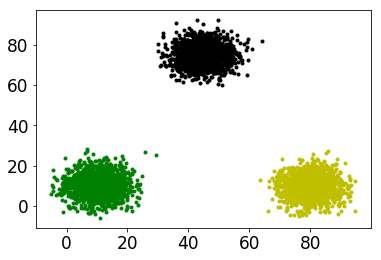

In [6]:
plot_blobs_3(feature, label)

In [7]:
inputs = tf.placeholder(tf.float32, [None, 2], name='inputs')
targets = tf.placeholder(tf.float32, [None, 3], name='targets')
input_shortcut = tf.placeholder(tf.float32, [None, 2], name='input_shortcut')
train_flag = tf.placeholder(tf.bool, name='training')

net = tflearn.fully_connected(inputs, 2000, activation='relu')
feature_transform = tflearn.fully_connected(net, 2, activation='relu')
output = dense_custom(tf.cond(train_flag, lambda: feature_transform,
                              lambda: input_shortcut),
                      2, 3, activation=None)

#This part is for computing the accuracy of this model
pred_y = tf.nn.softmax(output)
pred_y_true = tf.argmax(pred_y, 1)
y_true = tf.argmax(targets, 1)
correct_prediction = tf.equal(pred_y_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss function and optimizer
cost = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=targets)))

step_adam = tf.train.AdamOptimizer(1e-4).minimize(cost)
step_momentum = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cost)
step_gd = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

step_sgd_previous_layer = tf.train.GradientDescentOptimizer(0.0001).minimize(cost,
                        var_list = previous_layer_variables)

optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-4)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost,
                        var_list = last_layer_variables)
optimizer_m_last_layer = tf.train.MomentumOptimizer(1e-4, 0.9)
step_m_last_layer = optimizer_m_last_layer.minimize(cost,
                        var_list = last_layer_variables)


config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

In [8]:
def optmizer(optimizer_step, epochs):

    for i in (range(epochs)):
        epoch_loss = []
        start_epoch = time.time()
        dict_input = {inputs:feature, targets:label_hot, train_flag: True, 
                     input_shortcut: np.zeros([100, 2])}

        c, _ = session.run([cost, optimizer_step], feed_dict=dict_input)
        epoch_loss.append(c)
        if i%1000==0:
            print("Epoche: {}/{}".format(i+1, epochs), "| Training accuracy: ", session.run(accuracy, feed_dict=dict_input), 
                  "| Cost: {}".format(np.mean(epoch_loss)), " | Time for epoch: {:.2f}s".format(time.time() - start_epoch))

In [18]:
optmizer(step_gd, 40000)

('Epoche: 1/40000', '| Training accuracy: ', 0.99999976, '| Cost: 5.96509707975e-05', ' | Time for epoch: 0.02s')
('Epoche: 1001/40000', '| Training accuracy: ', 0.99999976, '| Cost: 5.0630493206e-05', ' | Time for epoch: 0.01s')
('Epoche: 2001/40000', '| Training accuracy: ', 0.99999976, '| Cost: 4.29609062849e-05', ' | Time for epoch: 0.01s')
('Epoche: 3001/40000', '| Training accuracy: ', 0.99999976, '| Cost: 3.64833394997e-05', ' | Time for epoch: 0.01s')
('Epoche: 4001/40000', '| Training accuracy: ', 0.99999976, '| Cost: 3.09196911985e-05', ' | Time for epoch: 0.01s')
('Epoche: 5001/40000', '| Training accuracy: ', 0.99999976, '| Cost: 2.62699941231e-05', ' | Time for epoch: 0.01s')
('Epoche: 6001/40000', '| Training accuracy: ', 0.99999976, '| Cost: 2.22958515224e-05', ' | Time for epoch: 0.01s')
('Epoche: 7001/40000', '| Training accuracy: ', 0.99999976, '| Cost: 1.89177881111e-05', ' | Time for epoch: 0.01s')
('Epoche: 8001/40000', '| Training accuracy: ', 0.99999976, '| Cost:

In [76]:
def plot_temp_all_3(feature, label, feature_t, label_t, 
                    name=None):
    pylab.figure()
    red = feature[label == 0]
    blue = feature[label == 1]
    c = feature[label == 2]
    green = feature_t[label_t == 0]
    black = feature_t[label_t == 1]
    yellow = feature_t[label_t == 2]

    pylab.plot(red[:, 0], red[:, 1], 'r.')
    pylab.plot(blue[:, 0], blue[:, 1], 'b.')
    pylab.plot(c[:, 0], c[:,1], 'c.')
    pylab.plot(green[:, 0], green[:, 1], 'g.')
    pylab.plot(black[:, 0], black[:, 1], 'k.')
    pylab.plot(yellow[:, 0], yellow[:, 1], 'y.')
    pylab.xticks(fontsize=17)
    pylab.yticks(fontsize=17)
    if name==None:
        pylab.show()
    else:
        pylab.savefig(name)


def random_points_3(start_x, end_x, start_y, end_y, size, random_state):
	np.random.seed(random_state)
	x1 = np.random.uniform(start_x, end_x, size)
	x2 = np.random.uniform(start_y, end_y, size)
	feature =  np.vstack([x1,x2]).transpose()
	label = np.random.choice(3,size)
	return feature, label

def get_svm(feature, label):
    from sklearn.svm import LinearSVC
    clf = LinearSVC(multi_class='ovr')
    clf.fit(feature, label)
    return clf

In [77]:
# def get_transform_feature():
feature_t = session.run(feature_transform, 
            feed_dict={inputs:feature, targets:label_hot, 
                       train_flag: True, 
                       input_shortcut: np.zeros([100, 2])})
label_t = label
feature_t = np.array(feature_t)


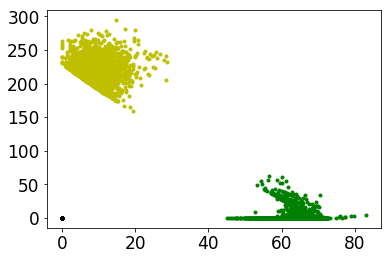

In [78]:
plot_blobs_3(feature_t, label_t)

# Original space

In [79]:
feature_random, label_random = random_points_3(-20,
    100,-20,100, 30000,
    random_state=100)
label_random = to_categorical(label_random, 3)
pre_label_nn= session.run(
    pred_y_true,
    feed_dict={inputs:feature_random, 
               targets:label_random,
               train_flag: True, 
               input_shortcut: feature_random})

clf = get_svm(feature, label)
pre_label_svm = clf.predict(feature_random)


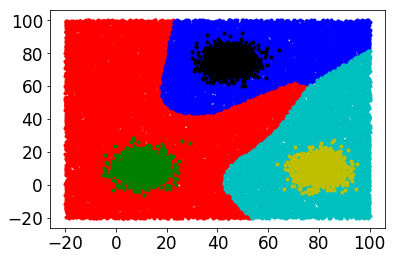

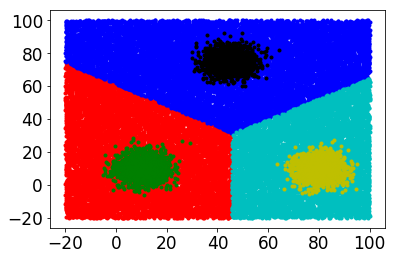

In [80]:
plot_temp_all_3(feature_random, pre_label_nn,feature, label_t)
plot_temp_all_3(feature_random, pre_label_svm,feature, label_t)

In [81]:
plot_temp_all_3(feature_random, pre_label_nn,feature, label_t , '../result/adam_3_class/nn_original.png')
plot_temp_all_3(feature_random, pre_label_svm,feature, label_t, '../result/adam_3_class/svm_original.png')

# transformed space

In [82]:
feature_random, label_random = random_points_3(0,
    100,0,300, 30000,
    random_state=100)
label_random = to_categorical(label_random, 3)
pre_label_nn= session.run(
    pred_y_true,
    feed_dict={inputs:feature_random, 
               targets:label_random,
               train_flag: False, 
               input_shortcut: feature_random})

clf = get_svm(feature_t, label_t)
pre_label_svm = clf.predict(feature_random)

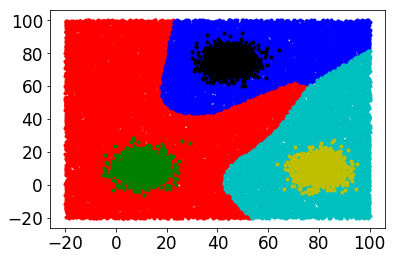

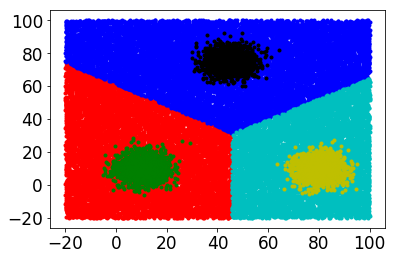

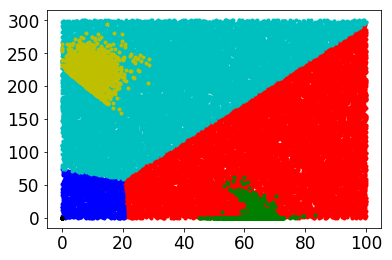

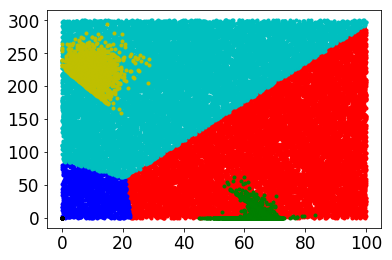

In [83]:
plot_temp_all_3(feature_random, pre_label_nn,feature_t, label_t)
plot_temp_all_3(feature_random, pre_label_svm,feature_t, label_t)

In [85]:
plot_temp_all_3(feature_random, pre_label_nn,feature_t, label_t, '../result/adam_3_class/nn_transformed.png')
plot_temp_all_3(feature_random, pre_label_svm,feature_t, label_t, '../result/adam_3_class/svm_transformed.png')